<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>I – Introduction</h2>

<p>
Ce notebook a pour objectif principal la <b>mise en œuvre et l’analyse d’une
stratégie de fusion de modèles</b> combinant les logits issus de deux architectures
de vision pré-entraînées, <b>Swin Transformer</b> et <b>ConvNeXt</b>, avec un
<b>modèle baseline reposant sur des features construites manuellement</b>. Les
logits utilisés sont extraits des <b>jeux de validation et de test</b>, sans
ré-entraînement des modèles image, afin d’évaluer la <b>complémentarité réelle</b>
entre les signaux visuels et les informations issues des features explicites dans
une logique d’amélioration des performances globales.
</p>

<p>
Dans un premier temps, ce notebook procède à <b>l’import des logits associés aux
jeux de validation et de test</b>, qui constituent les entrées des analyses
comparatives et des expériences de fusion présentées par la suite.
</p>

</div>


In [ ]:
import json

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, log_loss
from sklearn.model_selection import train_test_split

import sys
sys.path.insert(0, '../exploratory')
from data import load_data, encode_labels
from utils.calibration import fit_temperature, calibrated_probas, normalize_probas, weights_from_logloss
from visualization import plot_classification_report, plot_f1_comparison_with_delta

from sklearn.preprocessing import LabelEncoder

In [4]:
_, X_val, X_test, _, y_val, y_test = load_data(splitted=True).values()

y_val = encode_labels(y_val.tolist())
y_test = encode_labels(y_test.tolist())

idx = np.arange(len(y_val))

idx_meta, idx_eval = train_test_split(
    idx,
    test_size=0.30,
    random_state=42,
    stratify=y_val
)

In [3]:
# image

# Probabilités et logits sur la validation
logits_val_cn = np.load("../predictions/image/logits_convnext_val.npz")['logits']
logits_val_swin = np.load("../predictions/image/logits_swin_val.npz")['logits']
P_val_lr = np.load("../predictions/image/proba_cal_lr_val.npy")
logits_test_cn = np.load("../predictions/image/logits_convnext_test.npz")['logits']
logits_test_swin = np.load("../predictions/image/logits_swin_test.npz")['logits']
P_test_lr = np.load("../predictions/image/proba_cal_lr_test.npy")


# calibration des modèles
T_cn = fit_temperature(logits_val_cn, y_val)
T_swin = fit_temperature(logits_val_swin, y_val)
P_val_cn = calibrated_probas(logits_val_cn, T_cn)
P_val_swin = calibrated_probas(logits_val_swin, T_swin)
P_test_cn = calibrated_probas(logits_test_cn, T_cn)
P_test_swin = calibrated_probas(logits_test_swin, T_swin)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>II – Forces et faiblesses des modèles</h2>

<p>
Cette section vise à <b>analyser les forces et les faiblesses respectives des
modèles Swin Transformer et ConvNeXt</b> à travers une comparaison détaillée de
leurs performances <b>catégorie par catégorie</b>. Plutôt qu’une lecture
uniquement globale des scores, cette approche permet d’identifier les classes
pour lesquelles chaque modèle apporte une information visuelle pertinente, ainsi
que celles pour lesquelles leur contribution demeure limitée.
</p>

<p>
Cette lecture fine des résultats constitue une étape préalable essentielle à la
fusion des modèles, en fournissant des éléments d’interprétation sur la nature
des signaux capturés par chaque architecture et sur leur <b>valeur ajoutée
relative selon les catégories</b>.
</p>

</div>

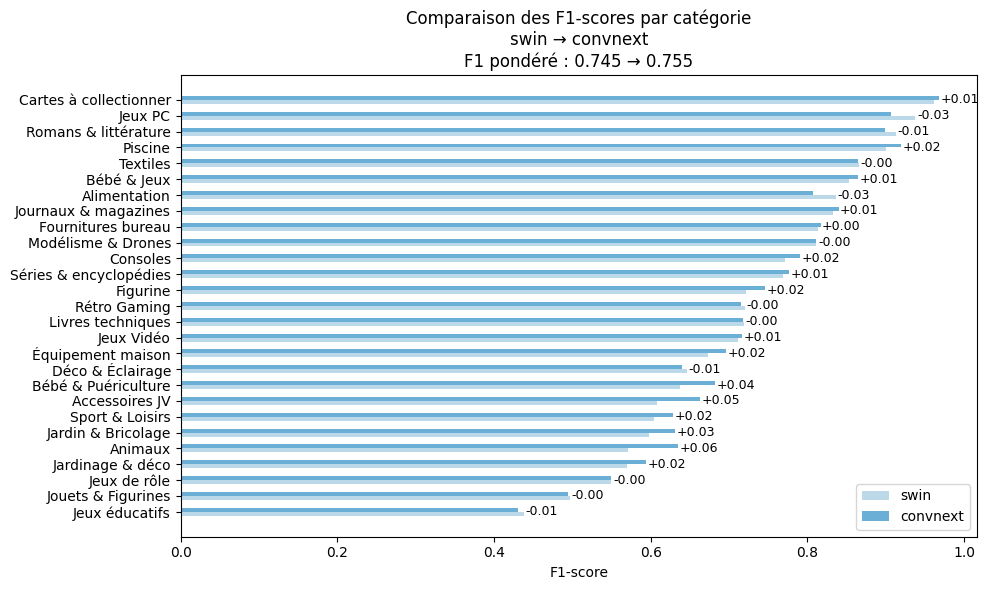

In [5]:
y_pred_cn = np.argmax(P_test_cn, axis=1)
y_pred_swin = np.argmax(P_test_swin, axis=1)

plot_f1_comparison_with_delta(y_test, y_pred_cn, y_pred_swin, new_name="convnext", ref_name="swin", encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse comparative Swin Transformer vs ConvNeXt</h3>

<p>
Globalement, <b>ConvNeXt (f1_new)</b> surpasse légèrement <b>Swin Transformer
(f1_ref)</b>, avec un <b>F1-score pondéré de 0.755 contre 0.745</b>. Ce gain reste
modéré mais cohérent, et s’explique par des améliorations localisées sur plusieurs
catégories spécifiques.
</p>

<p>
Les gains les plus marqués en faveur de ConvNeXt sont observés sur les catégories
<b>Animaux (+0.06)</b>, <b>Accessoires JV (+0.05)</b>, <b>Bébé &amp;
Puériculture (+0.04)</b> et <b>Jardin &amp; Bricolage (+0.03)</b>. Ces catégories
présentent des <b>images visuellement très diverses</b> (multiplicité des objets,
variations de contexte, d’échelle et de cadrage), suggérant que ConvNeXt est plus
robuste à cette hétérogénéité visuelle et parvient à mieux généraliser à partir de
motifs locaux récurrents, malgré une forte variabilité globale.
</p>

<p>
À l’inverse, Swin Transformer conserve un léger avantage ou une stabilité sur
certaines catégories telles que <b>Jeux éducatifs</b>, <b>Déco &amp;
Éclairage</b>, <b>Alimentation</b>, <b>Jeux PC</b> ou <b>Romans &amp;
littérature</b>, où les écarts restent faibles mais parfois défavorables à
ConvNeXt.
</p>

<p>
Enfin, de nombreuses catégories affichent des <b>écarts quasi nuls</b> entre les
deux modèles, traduisant des performances très proches. Cela confirme que les
différences observées sont principalement <b>catégorie-dépendantes</b> et renforce
l’intérêt d’une <b>stratégie de fusion</b>, permettant d’exploiter la
complémentarité des signaux capturés par Swin Transformer et ConvNeXt.
</p>


<p>
Les différences de comportement observées entre Swin Transformer et ConvNeXt,
bien que modérées, suggèrent une <b>complémentarité potentielle</b> entre ces deux
architectures. Dans cette optique, une stratégie de fusion est mise en œuvre afin
d’exploiter conjointement leurs signaux respectifs, plutôt que de considérer les
modèles image de manière isolée.
</p>

</div>


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>III – Stratégie de fusion</h2>

<p>
La stratégie de fusion repose sur la combinaison des logits issus de
<b>ConvNeXt</b> et <b>Swin Transformer</b>, auxquels est ajouté un
<b>modèle baseline simple</b> basé sur une <b>régression linéaire entraînée sur des
features construites manuellement</b>. L’objectif est d’évaluer si ce modèle
simple, malgré sa complexité limitée, est en mesure d’apporter une
<b>information complémentaire</b> aux représentations apprises par les modèles
image profonds.
</p>

<p>
Deux approches de fusion sont évaluées : le <b>blending</b> et le <b>stacking</b>.
Pour le <b>blending</b>, les <b>poids de combinaison</b> sont déterminés à partir de
la <b>log loss calculée sur le jeu de validation</b>, afin de privilégier les
modèles produisant des probabilités mieux calibrées. Pour le <b>stacking</b>, le
méta-classifieur retenu est une <b>régression logistique</b>, entraînée à partir
des sorties des modèles de base.
</p>

<p>
Dans les deux cas, le <b>jeu de validation est scindé en deux sous-ensembles</b>
selon un ratio <b>70&nbsp;% / 30&nbsp;%</b>. La partie 70&nbsp;% est utilisée pour
l’estimation des paramètres de fusion (poids du blending ou entraînement du
méta-classifieur), tandis que <b>l’évaluation des performances est réalisée sur
les 30&nbsp;% restants</b>, garantissant une comparaison équitable et cohérente
entre les deux stratégies.
</p>

<p>
Pour chacune des méthodes de fusion, <b>quatre configurations de modèles</b> sont
testées, reposant sur les mêmes combinaisons de signaux :
</p>


<ul>
  <li>ConvNeXt + Swin Transformer</li>
  <li>ConvNeXt + régression linéaire (features image)</li>
  <li>Swin Transformer + régression linéaire (features image)</li>
  <li>ConvNeXt + Swin Transformer + régression linéaire (features image)</li>
</ul>

</div>



In [16]:
probas_img = {
    "convnext": P_val_cn,
    "swin": P_val_swin,
    "lr_image": P_val_lr,
}

configs_img = {
    "ConvNeXt + Swin": ["convnext", "swin"],
    "ConvNeXt + LR image": ["convnext", "lr_image"],
    "Swin + LR image": ["swin", "lr_image"],
    "ConvNeXt + Swin + LR image": ["convnext", "swin", "lr_image"],
}

rows = []

for config_name, models in configs_img.items():
    
    log_losses = {
        m: log_loss(y_val, probas_img[m])
        for m in models
    }

    weights = weights_from_logloss(log_losses)

    P_blend = sum(weights[m] * probas_img[m] for m in models)
    P_blend = normalize_probas(P_blend)

    y_pred = np.argmax(P_blend, axis=1)

    f1 = f1_score(
        y_val[idx_eval],
        y_pred[idx_eval],
        average="weighted"
    )

    ll = log_loss(
        y_val[idx_eval],
        P_blend[idx_eval]
    )

    rows.append({
        "configuration": config_name,
        "w_convnext": weights.get("convnext", 0.0),
        "w_swin": weights.get("swin", 0.0),
        "w_lr_image": weights.get("lr_image", 0.0),
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_blending_img = pd.DataFrame(rows).set_index("configuration")



rows = []

for config_name, models in configs_img.items():

    X_meta = np.concatenate([probas_img[m] for m in models], axis=1)

    X_meta_train = X_meta[idx_meta]
    X_meta_eval = X_meta[idx_eval]

    y_train = y_val[idx_meta]
    y_eval = y_val[idx_eval]

    meta_model = LogisticRegression(
        max_iter=3000,
        n_jobs=-1,
    )

    meta_model.fit(X_meta_train, y_train)

    P_eval = meta_model.predict_proba(X_meta_eval)
    P_eval = P_eval / P_eval.sum(axis=1, keepdims=True)

    y_pred = np.argmax(P_eval, axis=1)

    f1 = f1_score(
        y_eval,
        y_pred,
        average="weighted"
    )

    ll = log_loss(
        y_eval,
        P_eval
    )

    rows.append({
        "configuration": config_name,
        "f1_weighted": f1,
        "log_loss": ll,
    })

df_stacking_img = pd.DataFrame(rows).set_index("configuration")

scores_img = pd.concat(
    [df_blending_img, df_stacking_img],
    axis=0
)

scores_img.index = [
    "blending - " + idx if i < len(df_blending_img)
    else "stacking - " + idx
    for i, idx in enumerate(scores_img.index)
]

scores_img

,w_convnext,w_swin,w_lr_image,f1_weighted,log_loss
blending - ConvNeXt + Swin,0.501148,0.498852,0.000000,0.762965,0.885142
blending - ConvNeXt + LR image,0.709440,0.000000,0.290560,0.748445,1.037881
blending - Swin + LR image,0.000000,0.708493,0.291507,0.748978,1.046152
blending - ConvNeXt + Swin + LR image,0.415804,0.413899,0.170297,0.762352,0.934053
stacking - ConvNeXt + Swin,NaN,NaN,NaN,0.763178,0.901284
stacking - ConvNeXt + LR image,NaN,NaN,NaN,0.750754,0.949527
stacking - Swin + LR image,NaN,NaN,NaN,0.748118,0.967770
stacking - ConvNeXt + Swin + LR image,NaN,NaN,NaN,0.763819,0.892041


<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h3>Analyse des résultats de la fusion</h3>

<p>
Les résultats obtenus mettent en évidence des <b>comportements sensiblement
différents entre les stratégies de blending et de stacking</b>, ainsi qu’un rôle
contrasté du modèle basé sur des features simples selon la méthode de fusion
retenue.
</p>

<p>
Dans le cas du <b>blending</b>, l’ajout du modèle de <b>régression linéaire basé sur
des features image manuelles</b> entraîne une <b>dégradation nette des
performances</b>. Les configurations combinant ConvNeXt ou Swin avec ce modèle
simple présentent un F1-score pondéré inférieur à celui obtenu par la fusion des
deux Transformers seuls, et s’accompagnent d’une <b>log loss significativement
plus élevée</b>, traduisant une mauvaise calibration des probabilités. Ce phénomène
s’explique par le fait que le blending repose sur une combinaison directe des
logits, rendant la méthode sensible à l’introduction de signaux moins fiables ou
moins bien calibrés.
</p>

<p>
À l’inverse, dans le cadre du <b>stacking</b>, l’intégration du modèle basé sur des
features simples conduit à une <b>amélioration systématique des performances</b>.
Le méta-classifieur (régression logistique) est en mesure de <b>pondérer
sélectivement les différentes sources d’information</b>, exploitant les signaux
pertinents du modèle simple tout en atténuant ses faiblesses. La configuration
combinant ConvNeXt, Swin Transformer et la régression linéaire atteint ainsi les
meilleurs résultats parmi les approches de stacking.
</p>

<p>
Malgré cet apport positif des features simples en stacking, la
<b>meilleure configuration globale</b> demeure le <b>blending des deux modèles
Transformer</b> (ConvNeXt + Swin), qui obtient le <b>meilleur compromis entre
performance et calibration</b>. Les poids associés à cette fusion sont
<b>très proches</b>, indiquant une contribution équilibrée des deux architectures
et confirmant leur forte complémentarité lorsqu’elles sont combinées sans
l’ajout de signaux externes.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>IV – Évaluation finale et enregistrement de la configuration</h2>

<p>
Cette section est dédiée au <b>test de la configuration de fusion retenue</b>. L’objectif est de <b>valider la capacité de généralisation</b> de la
stratégie de fusion identifiée comme la plus performante lors des analyses
précédentes. Au-delà de l’évaluation des performances, les <b>prédictions, probabilités et
paramètres de la fusion</b> sont <b>enregistrés</b> afin de permettre la
<b>réutilisation de la configuration finale</b>.
</p>

</div>



In [17]:
w_cn, w_swin = df_blending_img.iloc[0,:2]

P_val = w_cn * P_val_cn + w_swin * P_val_swin
P_test = w_cn * P_test_cn + w_swin * P_test_swin

np.save("../models/fusion/image/proba_image_val.npy", P_val)
np.save("../models/fusion/image/proba_image_test.npy", P_test)

pipeline_params = {
    "weights": {
        "convnext": float(w_cn),
        "swin": float(w_swin),
    },
    "calibration": {
        "T_convnext": float(T_cn),
        "T_swin": float(T_swin),
    }
}

with open("../models/fusion/image/pipeline_image_params.json", "w") as f:
    json.dump(pipeline_params, f, indent=2)

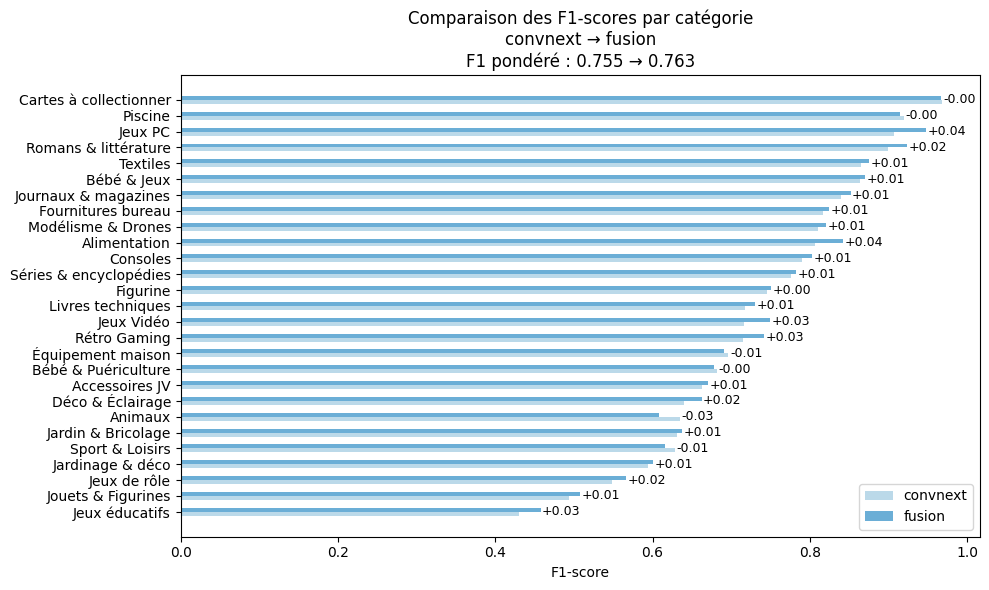

In [28]:
plot_f1_comparison_with_delta(y_test, y_pred, y_pred_cn, new_name="fusion", ref_name="convnext", encoder=encoder)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
Le passage de <b>ConvNeXt seul (F1 pondéré = 0.755)</b> à la <b>fusion ConvNeXt +
Swin (F1 pondéré = 0.763)</b> met en évidence un <b>gain global réel mais modéré</b>,
cohérent avec l’objectif de la stratégie de fusion. L’analyse par catégorie montre
que cette amélioration est <b>largement distribuée</b>, avec une majorité de
classes présentant des gains faibles mais réguliers (+0.01 à +0.04), suggérant
que la fusion agit principalement comme un mécanisme de <b>stabilisation et de
meilleure calibration des prédictions</b>.
</p>

<p>
Les progressions les plus notables concernent notamment <b>Jeux PC</b>,
<b>Alimentation</b>, <b>Jeux éducatifs</b>, <b>Jeux Vidéo</b> et <b>Rétro
Gaming</b>, catégories pour lesquelles la fusion permet d’affiner les décisions
sans modifier profondément la hiérarchie des classes. À l’inverse, quelques
dégradations localisées sont observées, la plus marquée concernant la catégorie
<b>Animaux (-0.03)</b>. Cette baisse reste toutefois à relativiser, Swin étant
déjà significativement moins performant que ConvNeXt sur cette classe
(-0.06), la fusion permettant au contraire d’en <b>atténuer partiellement la
faiblesse</b>.
</p>

</div>

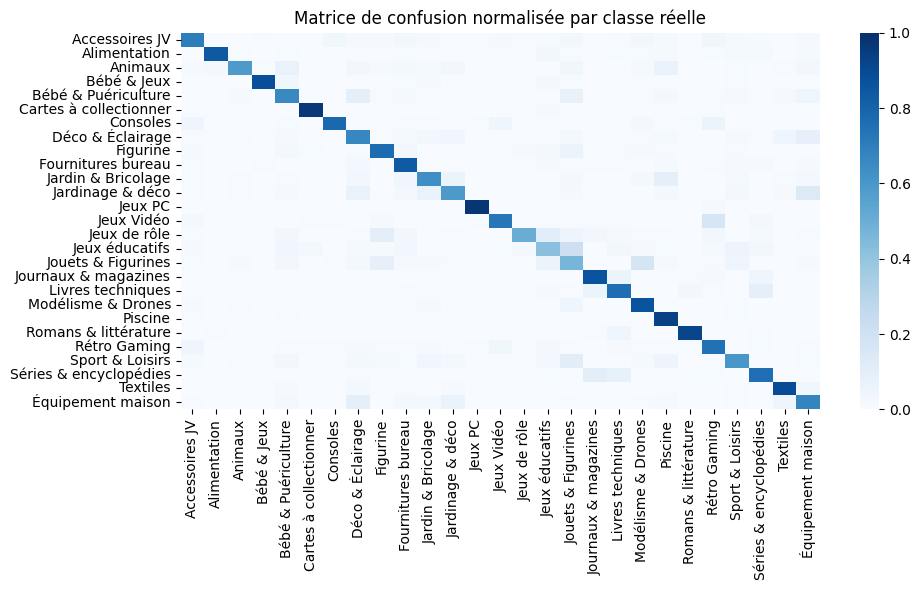


Classes avec les meilleurs scores F1 (top 5)


,precision,recall,f1-score,support
Cartes à collectionner,0.968,0.966,0.967,593.0
Jeux PC,0.921,0.977,0.948,131.0
Romans & littérature,0.927,0.920,0.924,414.0
Piscine,0.899,0.932,0.915,1531.0
Textiles,0.857,0.893,0.875,646.0



Classes avec les plus faibles scores F1 (bottom 5)


,precision,recall,f1-score,support
Animaux,0.629,0.589,0.608,124.0
Jardinage & déco,0.611,0.590,0.600,388.0
Jeux de rôle,0.644,0.504,0.566,115.0
Jouets & Figurines,0.550,0.472,0.508,731.0
Jeux éducatifs,0.496,0.424,0.458,311.0



Confusions les plus fréquentes (top 5)


,Classe réelle,Classe prédite,% des prédictions de la classe réelle
0,Jeux éducatifs,Jouets & Figurines,21.9
1,Jouets & Figurines,Modélisme & Drones,17.1
2,Jeux Vidéo,Rétro Gaming,16.4
3,Jardinage & déco,Équipement maison,13.7
4,Jeux de rôle,Jeux éducatifs,11.3


In [27]:
plot_classification_report(y_test, y_pred, encoder=encoder, k_best_f1=5)

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<p>
L’analyse intrinsèque des performances du modèle fusionné révèle une
<b>forte hétérogénéité selon les catégories</b>. Les meilleures performances sont
obtenues sur des classes visuellement ou sémantiquement bien définies telles que
<b>Cartes à collectionner</b>, <b>Jeux PC</b>, <b>Romans &amp; littérature</b>,
<b>Piscine</b> et <b>Textiles</b>, qui bénéficient d’indices visuels spécifiques
et peu ambigus. À l’inverse, les catégories les plus difficiles restent
<b>Animaux</b>, <b>Jardinage &amp; déco</b>, <b>Jeux de rôle</b>, <b>Jouets &amp;
Figurines</b> et <b>Jeux éducatifs</b>, caractérisées par une forte diversité
visuelle et des recouvrements sémantiques importants.
</p>

<p>
Les confusions les plus fréquentes confirment ces limites structurelles, en
opposant principalement des classes conceptuellement proches, comme
<b>Jeux éducatifs</b> et <b>Jouets &amp; Figurines</b>, <b>Jeux Vidéo</b> et
<b>Rétro Gaming</b>, ou encore <b>Jardinage &amp; déco</b> et <b>Équipement
maison</b>. Ces erreurs reflètent moins une faiblesse du modèle qu’une
<b>ambiguïté intrinsèque des catégories</b>, souvent difficile à lever à partir
du seul signal visuel.
</p>

<p>
Dans l’ensemble, la fusion ConvNeXt + Swin améliore les performances de manière
<b>cohérente et stable</b>, sans introduire de dégradation systémique, tout en
confirmant que les marges de progression restantes sont principalement liées à
des <b>limites sémantiques</b>. Ces résultats confortent l’intérêt de la fusion
image comme <b>socle robuste</b>, mais soulignent également la nécessité d’une
approche multimodale intégrant le texte pour lever les ambiguïtés persistantes.
</p>

</div>

<div style="background:#f0f8ff; padding:14px; border-radius:6px">

<h2>V - Conclusion</h2>

<p>
Ce notebook a permis de mettre en œuvre et d’analyser une <b>stratégie de fusion de
modèles image</b> combinant des architectures de vision modernes et un modèle
baseline plus simple. L’étude comparative entre ConvNeXt et Swin Transformer a
mis en évidence des <b>comportements différenciés selon les catégories</b>,
confirmant l’existence d’une complémentarité exploitable entre ces deux modèles.
</p>

<p>
Les expériences de fusion ont montré que les <b>features simples</b> peuvent jouer
un rôle positif dans un cadre de <b>stacking</b>, où le méta-classifieur est en
mesure de filtrer et pondérer les signaux, mais qu’elles <b>dégradent les
performances en blending</b>, en raison d’une mauvaise calibration des logits. La
meilleure configuration retenue est le <b>blending des deux Transformers</b>,
ConvNeXt et Swin, qui offre le meilleur compromis entre performance globale et
stabilité.
</p>

<p>
L’analyse par catégorie et des confusions a confirmé que les gains apportés par la
fusion sont <b>réels mais modérés</b>, et que les principales limites restantes
sont liées à des <b>ambiguïtés sémantiques intrinsèques</b> aux catégories,
difficilement résolubles à partir du seul signal visuel. Ces résultats
positionnent la fusion image comme un <b>socle robuste</b> pour la suite du
projet, tout en soulignant l’intérêt d’une <b>fusion multimodale intégrant le
texte</b> afin d’atteindre des performances optimales.
</p>

</div>

